In [1]:
import pandas as pd
import numpy as np
import json

import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.formula.api import logit, glm, mixedlm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Start analyses

In [2]:
# Preset variables
iti=200 # how long was the ITI between probes? (ms)
countdown=3000 # how long was the countdown

min_rt=300 # what is the minimum RT
max_rt=2500 # what is the maximum RT 
bin_size=5 # every 200 ms (1/5 = 0.200 seconds)

In [3]:
# Load the data
actual_data=np.load('data_files/trialdata_temporal_dict.npy',allow_pickle=True)

In [6]:
# Load information about the boundary locations and video lenghts
with open('boundary_dictionary.json') as f:
    boundary_info = json.load(f)

with open('length_dictionary.json') as f:
    length_info = json.load(f)

In [7]:
subject_data_dict=dict()
for sub in np.unique(actual_data[:,0]):
    sub_trials=actual_data[actual_data[:,0]==sub,3]
    
    conf_vals=[]
    for trial in sub_trials:
        if 'TrialName' in trial:
            conf_vals.append(np.int(trial['Confidence']))
        else:
            conf_vals.append(np.nan)
    
    zscore_conf=(conf_vals-np.nanmean(conf_vals))/np.nanstd(conf_vals)

    for t, trial in enumerate(sub_trials):
        if 'TrialName' in trial:
            trial['Zscore_Conf']=zscore_conf[t]                     
            
    actual_data[actual_data[:,0]==sub,3]=sub_trials
    
    subject_data_dict[sub]=[x for x in sub_trials if 'TrialName' in x]

In [209]:
remove_extra=1
restrict_rt=1

reorganized_data_dict=dict()

total_num_bounds=[]
total_num_nonbounds=[]
total_num_extra_space=[]
total_num_outofrange=[]
    
for sub in subject_data_dict.keys():
    
    num_bounds=0
    num_nonbounds=0
    
   # preset
    reorganized_data_dict[sub]=dict()
    reorganized_data_dict[sub]['names']=[]
    reorganized_data_dict[sub]['probe']=[]
    reorganized_data_dict[sub]['space_bars']=[]
    reorganized_data_dict[sub]['confidence']=[]
    reorganized_data_dict[sub]['confidence_z']=[]
    reorganized_data_dict[sub]['pixel_change']=[]
    reorganized_data_dict[sub]['rts']=[]


    real_trials=subject_data_dict[sub]
    
    subject_exclude_counter=0
    extra_spaces=[]
    outofrange_rt=[]
    
    for trial in real_trials:
        probe_num=trial['TrialName'].split('_')[-1].split('.')[0]

        ignore_trial=False # preset
            
        if len(trial['Spacebar'])==0:
            space_timing=np.nan
            rt_val=np.nan

        elif len(trial['Spacebar'])>1:

            # do you want to remove the trials when the pressed the space bar multiple times? or just the first spacebar?
            if remove_extra==1: 
                rt_val=np.nan
                ignore_trial=True
                subject_exclude_counter+=1

            else: 
                space_timing=trial['Spacebar'][0]
                rt_val=(space_timing-countdown)-int(probe_num)*iti

            extra_spaces.append(trial['TrialName'])

        else:
            space_timing=trial['Spacebar'][0]
            rt_val=(space_timing-countdown)-int(probe_num)*iti

        if 'non-visible' in trial['TrialName']:
            probe_type = 0 # not a probe
            avg_pix_change=np.nan # no pixel change calculation here

        else:

            probe_type = 1 # yes it's a probe

            file='pixel_changes/'+trial['TrialName'].split('/')[0]+'_pixel_changes.json'
            with open(file) as f:
                video_dict=json.load(f)

            avg_pix_change=video_dict[trial['TrialName']]

        # remember the trials with out of range RTs
        if rt_val > max_rt or rt_val < min_rt:

            outofrange_rt.append(rt_val)

            if restrict_rt==1:
                ignore_trial=True
                subject_exclude_counter+=1

        # check if boundary location
        boundary_locations=np.hstack(list(boundary_info[trial['TrialName'].split('/')[0]].values()))
        if np.int(probe_num) in boundary_locations and probe_type==1:
            num_bounds+=1
        elif probe_type==1:
            num_nonbounds+=1
            
        # only save if the trial isn't bein excluded for some reason
        if ignore_trial==False:
            reorganized_data_dict[sub]['names']+=[trial['TrialName']]
            reorganized_data_dict[sub]['probe']+=[probe_type]
            reorganized_data_dict[sub]['space_bars']+=[space_timing]
            reorganized_data_dict[sub]['confidence']+=[trial['Confidence']]
            reorganized_data_dict[sub]['confidence_z']+=[trial['Zscore_Conf']]
            reorganized_data_dict[sub]['pixel_change']+=[avg_pix_change]
            reorganized_data_dict[sub]['rts']+=[rt_val]
            
    if subject_exclude_counter >= 48: 
        print('excluding participant %s (%d trials ignored)' %(sub,subject_exclude_counter))
        reorganized_data_dict.pop(sub)
    else:
         # what percent of trials were dropped for this sub
        total_num_extra_space.append(len(extra_spaces)/len(real_trials))
        total_num_outofrange.append(len(outofrange_rt)/len(real_trials))
    
        # how many usable trials are there in our two conditions
        total_num_bounds.append(num_bounds)
        total_num_nonbounds.append(num_nonbounds)
   

excluding participant debugttmbJ:debugnddxM (55 trials ignored)


In [213]:
np.nanmean(total_num_extra_space)

0.01261467889908257

In [215]:
np.nanmean(total_num_outofrange)

0.0863914373088685

### Probe detection by event boundaries

In [13]:
all_probes_boundaries=[]
all_probes_nonboundaries=[]

num_bounds=[]
num_nonbounds=[]
for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_boundaries=[]
    probes_non_boundaries=[]
    
    for i, probe in enumerate(probe_names):

        if reorganized_data_dict[sub]['probe'][i]==1: # if its a probe trial 
            base=probe.split('/')[0]
            probe_num=probe.split('_')[-1].split('.')[0]

            boundary_locations=np.hstack(list(boundary_info[base].values()))

            if np.int(probe_num) in boundary_locations:
                probes_boundaries.append(~np.isnan(reorganized_data_dict[sub]['space_bars'][i]))

            else:
                probes_non_boundaries.append(~np.isnan(reorganized_data_dict[sub]['space_bars'][i]))

    print(sub,len(probes_boundaries),len(probes_non_boundaries))
    num_bounds.append(len(probes_boundaries))
    num_nonbounds.append(len(probes_non_boundaries))
    all_probes_boundaries.append(np.nansum(probes_boundaries)/len(probes_boundaries))
    all_probes_nonboundaries.append(np.nansum(probes_non_boundaries)/len(probes_non_boundaries))

debug07BY44:debugBE7Z9N 1 36
debug0J9fw:debug39W0J 3 59
debug0izns:debugZ2iHU 8 52
debug19lMm:debugUiFNq 5 45
debug1YAUU:debugJPQAT 2 48
debug26vse:debugR3Agl 3 51
debug2FTyl:debugGncPa 5 55
debug2LvDu:debugV32zh 3 61
debug2Mj1Y:debugBBWKj 5 56
debug2ieYE:debug92sb7 3 24
debug30eYX:debugpwEKv 4 39
debug4Kps0:debug4fG4D 3 29
debug7Eumu:debug4btcn 4 49
debug7hwht:debugz5Nro 5 55
debug8W1Uy:debugj2L8M 7 48
debug9BEep:debugtTzA2 4 56
debug9GH3Y:debugo010z 6 56
debug9wyVB:debugcIcCI 7 51
debugBKsVe:debugN7mkh 3 55
debugBbmu1:debugfJzHl 4 54
debugBx23R:debug52cgy 1 44
debugCncNG:debugbwj5M 1 60
debugDF3t3:debugDCEN9 3 56
debugDOgWA:debugEG23M 3 59
debugEeE98:debugDbY3a 4 50
debugEx8wN:debuggOnms 6 54
debugFLCue:debugEPGon 2 26
debugFPHyC:debugVd1hA 1 44
debugFmqbJ:debugmHku2 5 53
debugG2GQq:debugmAPMC 5 56
debugH1RD6:debugJW1Vh 5 57
debugHCXMt:debugpkyAP 7 52
debugJ001d:debugWtcvu 5 39
debugJrXob:debugkIH1E 3 53
debugLUdoV:debugxVWQ4 3 57
debugMC59V:debugZ7I6l 7 50
debugNoi0G:debugCt04Y 5 58

In [14]:
print('Average boundaries detected: = %0.4f (N=%0.2f average)'%(np.nanmean(all_probes_boundaries),
                                                             np.nanmean(num_bounds)))
print('Average non-boundaries detected: = %0.4f (N=%0.2f average)'%(np.nanmean(all_probes_nonboundaries),
                                                                    np.nanmean(num_nonbounds)))

Average boundaries detected: = 0.3320 (N=4.39 average)
Average non-boundaries detected: = 0.6106 (N=52.84 average)


In [15]:
np.nanstd(all_probes_boundaries)

0.27422121196240123

In [16]:
np.nanstd(all_probes_nonboundaries)

0.20803259177204717

Ttest_relResult(statistic=-11.357288017773131, pvalue=4.3309216395700005e-20)


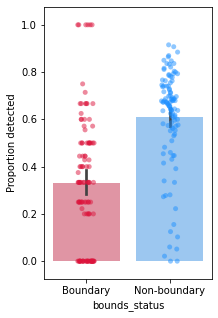

In [17]:
fig=plt.figure(figsize=(3,5))
bounds_detect_df=pd.DataFrame({'vals':np.hstack((all_probes_boundaries,all_probes_nonboundaries)),
                               'bounds_status':np.hstack((np.zeros(len(all_probes_boundaries)),
                                                          np.ones(len(all_probes_nonboundaries))))})

sns.barplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['crimson','dodgerblue'],alpha=0.5)
sns.stripplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['crimson','dodgerblue'],alpha=0.5)
plt.xticks([0,1],['Boundary','Non-boundary'])
plt.ylabel('Proportion detected')
plt.ylim(-0.075,1.075)
print(stats.ttest_rel(all_probes_boundaries,all_probes_nonboundaries,nan_policy='omit'))

fig.savefig('svgs/exp1_tempprobe/subjectwise_boundary_detection.svg')

In [18]:
# Cohen's D
difference = np.array(all_probes_boundaries) - np.array(all_probes_nonboundaries)
mean_diff = np.nanmean(difference)
sd_diff = np.nanstd(difference)

d = mean_diff/sd_diff
d

-1.097950474338238

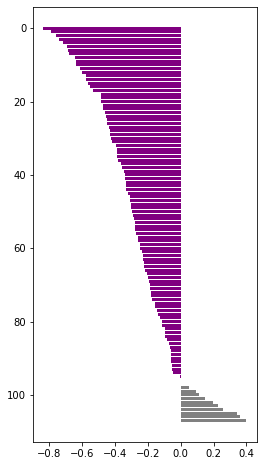

In [19]:
sub_differences=np.array(all_probes_boundaries)-np.array(all_probes_nonboundaries)

neg_vals=np.where(np.sort(sub_differences)<=0)[0]
pos_vals=np.where(np.sort(sub_differences)>=0)[0]
colors=np.hstack((np.repeat('purple',len(neg_vals)),np.repeat('grey',len(pos_vals))))

fig,ax=plt.subplots(1,figsize=(4,8))
ax.barh(np.arange(len(sub_differences)),np.sort(sub_differences),color=colors)
ax.invert_yaxis()
fig.savefig('svgs/exp1_tempprobe/subjectwise_boundary_detection_differences.svg')

In [20]:
np.sum(np.sort(sub_differences)<0)

96

In [21]:
np.sum(np.sort(sub_differences)>=0)

12

In [22]:
## Pre-registered analysis across all participants
all_vid_names=np.hstack(([reorganized_data_dict[sub]['names'] for sub in reorganized_data_dict.keys()]))
all_probe_status=np.hstack(([reorganized_data_dict[sub]['probe'] for sub in reorganized_data_dict.keys()]))
all_detections=np.hstack(([reorganized_data_dict[sub]['space_bars'] for sub in reorganized_data_dict.keys()]))

all_probes_boundaries=[]
all_probes_non_boundaries=[]

for i, probe in enumerate(all_vid_names):

    if all_probe_status[i]==1: # if its a probe trial 
        base=probe.split('/')[0]
        probe_num=probe.split('_')[-1].split('.')[0]

        boundary_locations=np.hstack(list(boundary_info[base].values()))

        if np.int(probe_num) in boundary_locations:
            all_probes_boundaries.append(all_detections[i])

        else:
            all_probes_non_boundaries.append(all_detections[i])


table=[[np.sum(np.isnan(all_probes_boundaries)),np.sum(~np.isnan(all_probes_boundaries))],
       [np.sum(np.isnan(all_probes_non_boundaries)),np.sum(~np.isnan(all_probes_non_boundaries))]]
print(table)

print(table[0][1]/len(all_probes_boundaries))
print(table[1][1]/len(all_probes_non_boundaries))

stats.fisher_exact(table, alternative='two-sided')

[[305, 174], [2150, 3610]]
0.36325678496868474
0.6267361111111112


(2.9431970061480888, 5.755631446686558e-29)

In [23]:
all_probes_boundaries=[]
all_probes_nonboundaries=[]

num_bounds=[]
num_nonbounds=[]
for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_boundaries=[]
    probes_non_boundaries=[]
    
    for i, probe in enumerate(probe_names):

        if reorganized_data_dict[sub]['probe'][i]==1: # if its a probe trial 
            base=probe.split('/')[0]
            probe_num=probe.split('_')[-1].split('.')[0]

            boundary_locations=np.hstack(list(boundary_info[base].values()))

            if np.int(probe_num) in boundary_locations:
                probes_boundaries.append(~np.isnan(reorganized_data_dict[sub]['space_bars'][i]))

            else:
                probes_non_boundaries.append(~np.isnan(reorganized_data_dict[sub]['space_bars'][i]))

    print(sub,len(probes_boundaries),len(probes_non_boundaries))
    num_bounds.append(len(probes_boundaries))
    num_nonbounds.append(len(probes_non_boundaries))
    all_probes_boundaries.append(np.nansum(probes_boundaries)/len(probes_boundaries))
    all_probes_nonboundaries.append(np.nansum(probes_non_boundaries)/len(probes_non_boundaries))

debug07BY44:debugBE7Z9N 1 36
debug0J9fw:debug39W0J 3 59
debug0izns:debugZ2iHU 8 52
debug19lMm:debugUiFNq 5 45
debug1YAUU:debugJPQAT 2 48
debug26vse:debugR3Agl 3 51
debug2FTyl:debugGncPa 5 55
debug2LvDu:debugV32zh 3 61
debug2Mj1Y:debugBBWKj 5 56
debug2ieYE:debug92sb7 3 24
debug30eYX:debugpwEKv 4 39
debug4Kps0:debug4fG4D 3 29
debug7Eumu:debug4btcn 4 49
debug7hwht:debugz5Nro 5 55
debug8W1Uy:debugj2L8M 7 48
debug9BEep:debugtTzA2 4 56
debug9GH3Y:debugo010z 6 56
debug9wyVB:debugcIcCI 7 51
debugBKsVe:debugN7mkh 3 55
debugBbmu1:debugfJzHl 4 54
debugBx23R:debug52cgy 1 44
debugCncNG:debugbwj5M 1 60
debugDF3t3:debugDCEN9 3 56
debugDOgWA:debugEG23M 3 59
debugEeE98:debugDbY3a 4 50
debugEx8wN:debuggOnms 6 54
debugFLCue:debugEPGon 2 26
debugFPHyC:debugVd1hA 1 44
debugFmqbJ:debugmHku2 5 53
debugG2GQq:debugmAPMC 5 56
debugH1RD6:debugJW1Vh 5 57
debugHCXMt:debugpkyAP 7 52
debugJ001d:debugWtcvu 5 39
debugJrXob:debugkIH1E 3 53
debugLUdoV:debugxVWQ4 3 57
debugMC59V:debugZ7I6l 7 50
debugNoi0G:debugCt04Y 5 58

In [24]:
condition_boundaries=dict({'collision':[],'containment':[],'falling':[],'occlusion':[]})

for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    temp_conditions=dict({'collision':[],'containment':[],'falling':[],'occlusion':[]})
    
    for i, probe in enumerate(probe_names):
        base=probe.split('/')[0]
        probe_num=probe.split('_')[-1].split('.')[0]

        for key in boundary_info[base].keys():
            boundary_locations=boundary_info[base][key]

            if np.int(probe_num) in boundary_locations:
                temp_conditions[key]+=[~np.isnan(reorganized_data_dict[sub]['space_bars'][i])]
 
        #all_boundary_locations=np.hstack(list(boundary_info[base].values()))

        #if np.int(probe_num) not in all_boundary_locations:

         #   temp_conditions['noboundary']+=[~np.isnan(reorganized_data_dict[sub]['space_bars'][i])]
          
    print(sub,[len(temp_conditions[i]) for i in temp_conditions.keys()])
    
    for key in condition_boundaries.keys():
        condition_boundaries[key]+=[np.nansum(temp_conditions[key])/len(temp_conditions[key])]

debug07BY44:debugBE7Z9N [0, 1, 0, 0]
debug0J9fw:debug39W0J [1, 2, 0, 0]
debug0izns:debugZ2iHU [1, 1, 2, 4]
debug19lMm:debugUiFNq [1, 1, 1, 2]
debug1YAUU:debugJPQAT [0, 0, 2, 0]
debug26vse:debugR3Agl [0, 0, 2, 1]
debug2FTyl:debugGncPa [0, 1, 1, 3]
debug2LvDu:debugV32zh [1, 2, 0, 0]
debug2Mj1Y:debugBBWKj [1, 1, 1, 2]
debug2ieYE:debug92sb7 [0, 0, 1, 2]
debug30eYX:debugpwEKv [1, 1, 1, 1]
debug4Kps0:debug4fG4D [0, 1, 0, 2]
debug7Eumu:debug4btcn [1, 1, 1, 1]
debug7hwht:debugz5Nro [1, 2, 1, 1]
debug8W1Uy:debugj2L8M [0, 1, 2, 4]
debug9BEep:debugtTzA2 [1, 1, 1, 1]
debug9GH3Y:debugo010z [1, 2, 1, 2]
debug9wyVB:debugcIcCI [0, 1, 1, 5]
debugBKsVe:debugN7mkh [1, 2, 0, 0]
debugBbmu1:debugfJzHl [1, 0, 2, 1]
debugBx23R:debug52cgy [0, 1, 0, 0]
debugCncNG:debugbwj5M [0, 1, 0, 0]
debugDF3t3:debugDCEN9 [1, 2, 0, 0]
debugDOgWA:debugEG23M [1, 2, 0, 0]
debugEeE98:debugDbY3a [1, 1, 1, 1]
debugEx8wN:debuggOnms [1, 2, 1, 2]
debugFLCue:debugEPGon [1, 1, 0, 0]
debugFPHyC:debugVd1hA [0, 1, 0, 0]
debugFmqbJ:debugmH

In [25]:
for key in condition_boundaries.keys():
    print(key,sum(~np.isnan(condition_boundaries[key])))

collision 68
containment 94
falling 74
occlusion 75


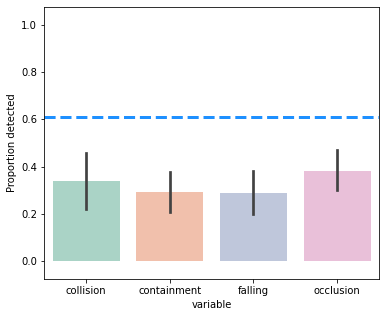

In [26]:
colors=sns.color_palette('Set2',4)

fig=plt.figure(figsize=(6,5))

bounds_detect_df=pd.DataFrame(condition_boundaries)
bounds_detect_df=bounds_detect_df.melt()

sns.barplot(x='variable',y='value',data=bounds_detect_df,palette=colors,alpha=0.6)
#sns.stripplot(x='variable',y='value',data=bounds_detect_df,palette=colors,alpha=0.6)
plt.xticks(np.arange(len(condition_boundaries.keys())),condition_boundaries.keys())
plt.ylabel('Proportion detected')
plt.ylim(-0.075,1.075)

plt.axhline(np.nanmean(all_probes_nonboundaries),
            color='dodgerblue',linestyle='dashed',linewidth=3)

fig.savefig('svgs/exp1_tempprobe/subjectwise_boundary_detection_by_type.svg')

In [27]:
for key in condition_boundaries.keys():
    print(key,np.nanmean(condition_boundaries[key]))
    print(stats.ttest_rel(condition_boundaries[key],all_probes_nonboundaries,nan_policy='omit'))

collision 0.3382352941176471
Ttest_relResult(statistic=-5.344012134020822, pvalue=1.1757821585810332e-06)
containment 0.2925531914893617
Ttest_relResult(statistic=-6.950171762087853, pvalue=4.93581688388592e-10)
falling 0.286036036036036
Ttest_relResult(statistic=-7.401699306999819, pvalue=1.8622654761874693e-10)
occlusion 0.38155555555555554
Ttest_relResult(statistic=-5.127848766543981, pvalue=2.269798040506694e-06)


In [28]:
## Pre-registered analysis 
for key in condition_boundaries.keys():
    print(key)
    
    all_probes_boundaries=[]
    
    for i, probe in enumerate(all_vid_names):

        if all_probe_status[i]==1 and key in probe: # if its a probe trial 
            base=probe.split('/')[0]
            probe_num=probe.split('_')[-1].split('.')[0]

            boundary_locations=np.hstack(list(boundary_info[base].values()))

            if np.int(probe_num) in boundary_locations:
                all_probes_boundaries.append(all_detections[i])

    table=[[np.sum(np.isnan(all_probes_boundaries)),np.sum(~np.isnan(all_probes_boundaries))],
           [np.sum(np.isnan(all_probes_non_boundaries)),np.sum(~np.isnan(all_probes_non_boundaries))]]
    print(table)

    print(table[0][1]/len(all_probes_boundaries))
    print(table[1][1]/len(all_probes_non_boundaries))

    print(stats.fisher_exact(table, alternative='two-sided'))
    print()

collision
[[80, 60], [2150, 3610]]
0.42857142857142855
0.6267361111111112
(2.2387596899224804, 3.4204526153328165e-06)

containment
[[149, 88], [2150, 3610]]
0.37130801687763715
0.6267361111111112
(2.842970401691332, 7.248252697209464e-15)

falling
[[145, 53], [2150, 3610]]
0.2676767676767677
0.6267361111111112
(4.593681439227732, 1.1910506033542691e-23)

occlusion
[[165, 114], [2150, 3610]]
0.40860215053763443
0.6267361111111112
(2.4302325581395348, 7.822789835410677e-13)



### Pixel changes 

In [173]:
# collapse across participants
all_vid_names=np.hstack(([reorganized_data_dict[sub]['names'] for sub in reorganized_data_dict.keys()]))
all_probe_status=np.hstack(([reorganized_data_dict[sub]['probe'] for sub in reorganized_data_dict.keys()]))
all_detections=np.hstack(([reorganized_data_dict[sub]['space_bars'] for sub in reorganized_data_dict.keys()]))
all_pixels=np.hstack(([reorganized_data_dict[sub]['pixel_change'] for sub in reorganized_data_dict.keys()]))
all_confidences=np.hstack(([reorganized_data_dict[sub]['confidence'] for sub in reorganized_data_dict.keys()]))
all_rts=np.hstack(([reorganized_data_dict[sub]['rts'] for sub in reorganized_data_dict.keys()]))

# but remember to include the subject name so we can use it as a random effect 
all_sub_names=np.hstack(([np.repeat(sub,len(reorganized_data_dict[sub]['names'])) 
                          for sub in reorganized_data_dict.keys()]))

all_boundary_status=[]
for i, probe in enumerate(all_vid_names):
    if all_probe_status[i]==1: # if its a probe trial 
        base=probe.split('/')[0]
        probe_num=probe.split('_')[-1].split('.')[0] 

        boundary_locations=np.hstack(list(boundary_info[base].values()))
        
        if np.int(probe_num) in boundary_locations:
            all_boundary_status.append(1)
        else:
            all_boundary_status.append(0)

In [188]:
temp_detection=all_detections.copy()
temp_detection[~np.isnan(temp_detection)]=1
temp_detection[np.isnan(temp_detection)]=0


all_trial_df=pd.DataFrame({
    'subject':all_sub_names[all_probe_status==1],
    'pixels':all_pixels[all_probe_status==1],
    'detection':temp_detection[all_probe_status==1],
    'confidence':np.array(all_confidences[all_probe_status==1],dtype=float),
    'RTs':all_rts[all_probe_status==1],
    'condition':all_boundary_status})


#some NANs in pixels -- need to delete
all_trial_df= all_trial_df.dropna(subset=['pixels'])

all_trial_df.head()

,subject,pixels,detection,confidence,RTs,condition
0,debug07BY44:debugBE7Z9N,0.017284,1.0,36.0,857.0,0
1,debug07BY44:debugBE7Z9N,0.067348,0.0,39.0,NaN,0
2,debug07BY44:debugBE7Z9N,0.034293,0.0,38.0,NaN,0
3,debug07BY44:debugBE7Z9N,0.016140,0.0,67.0,NaN,0
4,debug07BY44:debugBE7Z9N,0.083869,1.0,54.0,1069.0,0


In [190]:
# building the model and fitting the data
#log_reg = logit(formula=('detection ~ pixels + C(condition)'), data=all_trial_df).fit()

log_reg = mixedlm(formula=('detection ~ pixels + C(condition)'), data=all_trial_df,
                 groups=all_trial_df['subject']).fit()


# printing the summary table
print(log_reg.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  detection 
No. Observations:    6231     Method:              REML      
No. Groups:          109      Scale:               0.2024    
Min. group size:     26       Log-Likelihood:      -4000.5872
Max. group size:     64       Converged:           Yes       
Mean group size:     57.2                                    
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          0.613    0.020  30.695 0.000  0.574  0.652
C(condition)[T.1] -0.270    0.022 -12.491 0.000 -0.312 -0.228
pixels             0.015    0.121   0.123 0.902 -0.222  0.252
Group Var          0.036    0.012                            



### Comparison with naive participants 

In [101]:
eventseg_data=np.load('data_files/eventseg_trialdata_dict.npy',allow_pickle=True)

In [102]:
real_trials=[x for x in eventseg_data[:,3] if 'TrialName' in x]
real_trials=[x for x in real_trials if len(x['Boundaries']) >= 1 
             or len(x['Removed_Presses']) >= 1]
print(len(real_trials))

640


In [103]:
# get the boundary info in a different format 
boundary_info_sec={}
boundary_numbers=[]
for uv in boundary_info:
    locations=np.hstack(list(boundary_info[uv].values()))
    
    locations_ms=[i*iti/1000 for i in locations]
    boundary_info_sec[uv]=locations_ms
    
    boundary_numbers.append(len(locations))

collision_collision311
20
(53, 20)
Number of events: 1-6 (average=2.45)
collision_collision312
20
(63, 20)
Number of events: 1-10 (average=2.70)
collision_containment315
20
(71, 20)
Number of events: 1-7 (average=3.30)
collision_containment5313
20
(63, 20)
Number of events: 1-7 (average=3.55)
collision_falling998
20
(60, 20)
Number of events: 1-7 (average=3.60)
collision_falling3998
20
(42, 20)
Number of events: 1-6 (average=3.20)
collision_occlusion315
20
(53, 20)
Number of events: 1-4 (average=1.85)
collision_occlusion3311
20
(44, 20)
Number of events: 1-4 (average=2.30)
containment_collision308
20
(52, 20)
Number of events: 1-5 (average=2.00)
containment_collision314
20
(56, 20)
Number of events: 1-7 (average=2.25)
containment_containment319
20
(34, 20)
Number of events: 1-3 (average=1.45)
containment_containment4320
20
(70, 20)
Number of events: 1-5 (average=2.30)
containment_falling998
20
(43, 20)
Number of events: 1-4 (average=2.15)
containment_falling2998
20
(39, 20)
Number of e

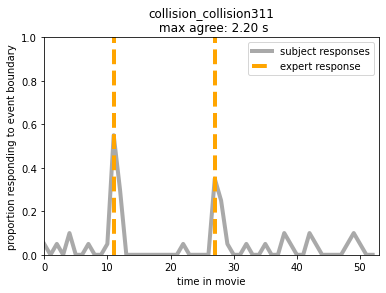

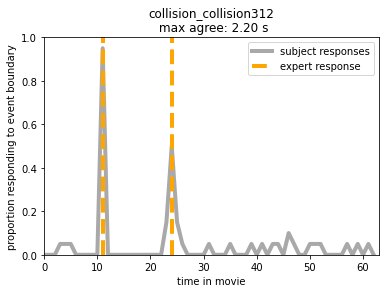

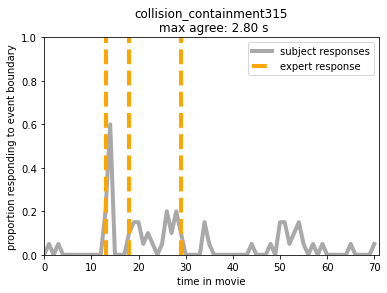

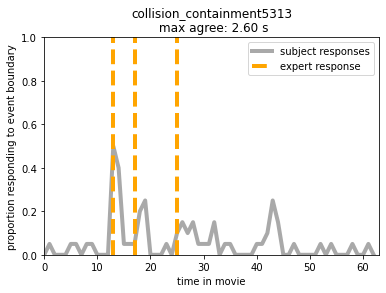

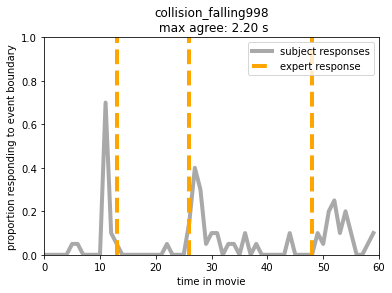

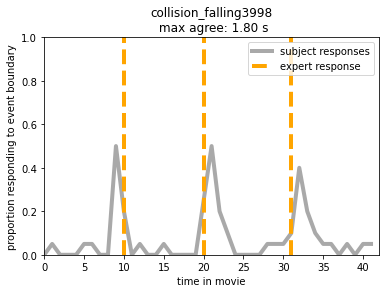

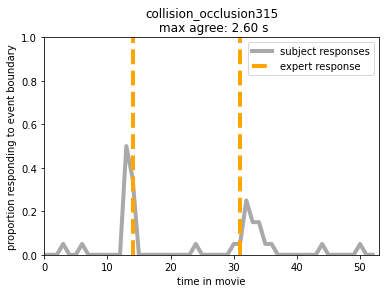

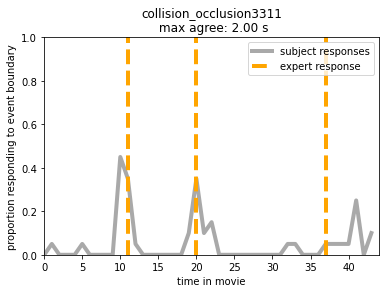

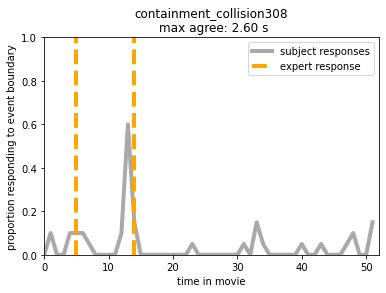

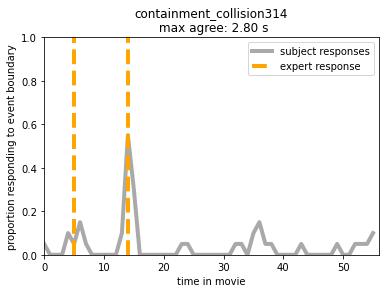

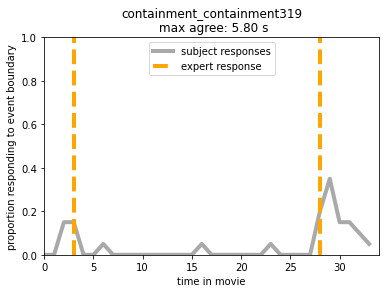

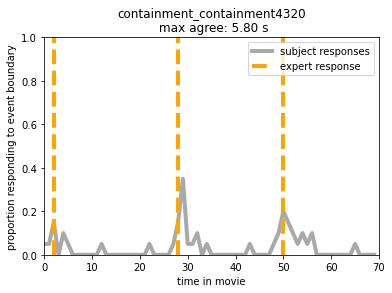

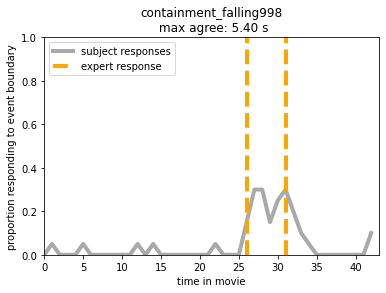

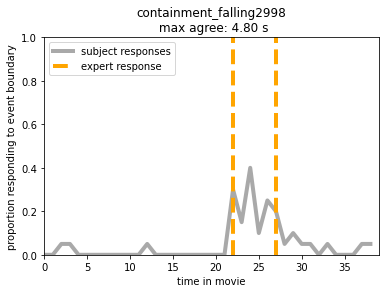

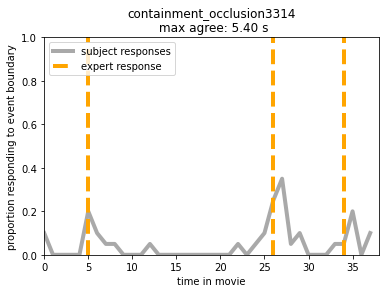

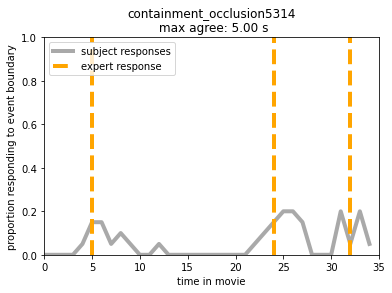

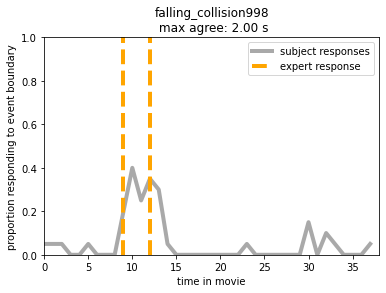

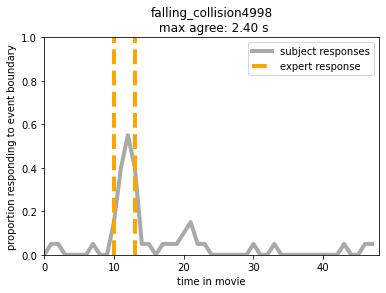

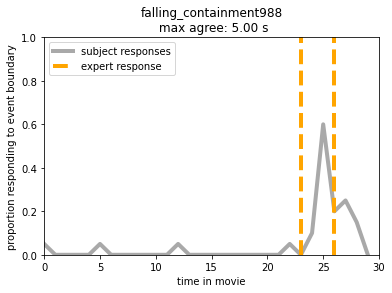

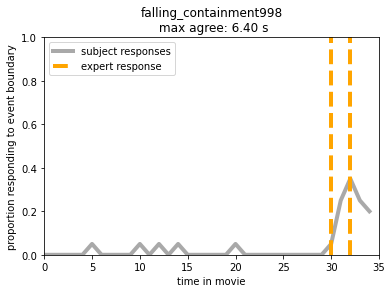

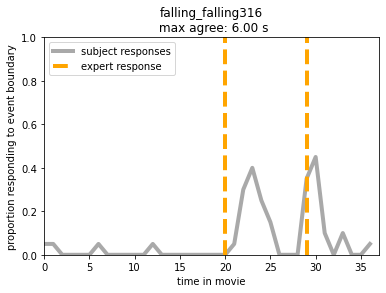

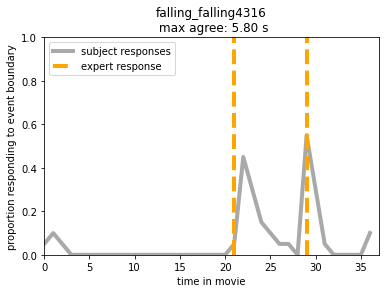

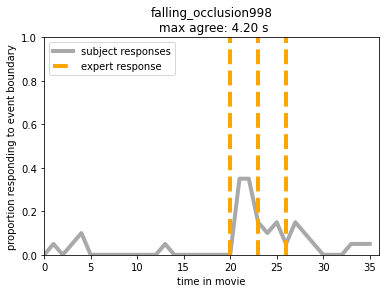

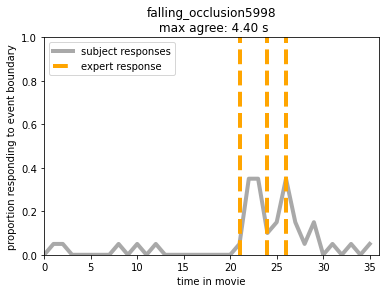

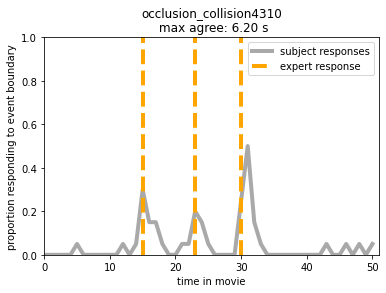

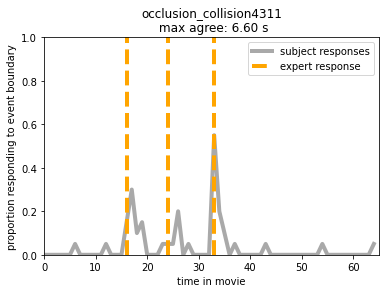

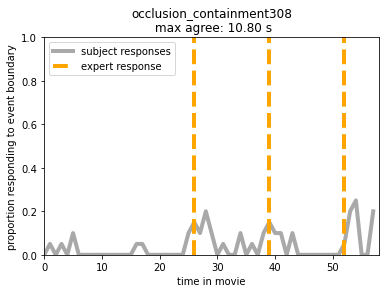

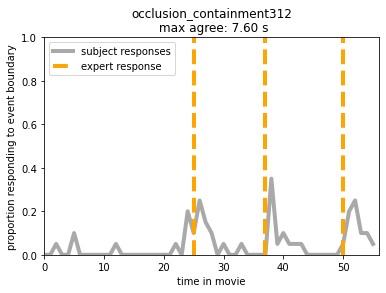

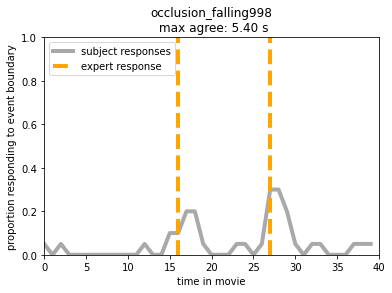

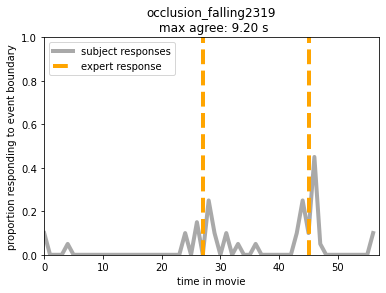

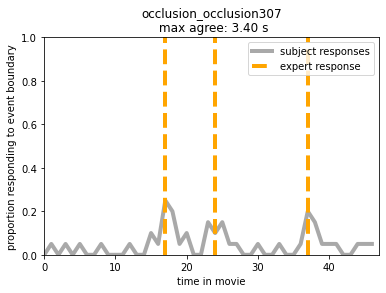

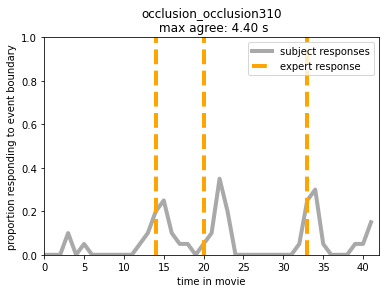

In [104]:
all_timecourses={}
percentages=[]
non_boundary_percentages=[]

all_numbers=[]
plot=True

max_agree_dict=dict()

all_removed=[]
all_pauses=[]

for vid in boundary_info_sec:
    print(vid)
    
    sub_trials=[x for x in real_trials if vid in x['TrialName']]
    print(len(sub_trials))

    duration=length_info[vid]
    
    duration_resample=duration*bin_size 

    # create an aggregate matrix of responses 
    output = np.zeros((np.int(np.round(duration_resample)), len(sub_trials)))

    for counter, ppt in enumerate(sub_trials):
        rounded_vals =  np.round(np.array(ppt['Boundaries'],dtype=float),decimals=1)

        if sum(rounded_vals*bin_size >= np.int(np.round(duration_resample))) > 0: # if any were at the end of the movie, ignore
            idx=np.where(rounded_vals*bin_size >= np.int(np.round(duration_resample)))[0]
            rounded_vals=np.delete(rounded_vals,idx)

        indices = np.array(rounded_vals*bin_size,dtype=int)
        output[indices,counter] = 1
        
        all_removed.extend(np.round(np.array(ppt['Removed_Presses'],dtype=float),decimals=1))
        all_pauses.extend(np.round(np.array(ppt['Boundary_On_Pause'],dtype=float),decimals=1))
        
    print(output.shape)

    average_keypresses = output.sum(axis=1)
    num_events=output.sum(axis=0)
    print('Number of events: %d-%d (average=%0.2f)' %(np.min(num_events),
                                                                 np.max(num_events),np.nanmean(num_events)))
    all_numbers.append(num_events)
    expert_bounds=np.array(boundary_info_sec[vid])*bin_size
    non_expert_bounds=np.delete(np.arange(len(average_keypresses)),np.array(expert_bounds,int))
    
    # what was the most agreed upon? 
    max_agree=(np.argmax(average_keypresses/len(sub_trials)))/bin_size
    max_agree_dict[vid]=max_agree
    
    if plot == True:
        fig=plt.figure()
        plt.plot(average_keypresses/len(sub_trials),color='darkgrey',lw=4)
        plt.title('%s\n max agree: %0.2f s' %(vid,max_agree))
        plt.xlabel("time in movie")
        plt.ylabel("proportion responding to event boundary")
        plt.axis([0, len(average_keypresses), 0, 1])

        for b in expert_bounds:
            plt.axvline(b,color='orange',linestyle='dashed',lw=4)

        plt.legend(['subject responses','expert response'])
        
        fig.savefig('svgs/exp1_tempprobe/boundary_placement_%s.svg' % vid)

    
    all_timecourses[vid]=average_keypresses/len(sub_trials)
    percentages.extend(average_keypresses[np.array(expert_bounds,int)]/len(sub_trials))
    non_boundary_percentages.extend(average_keypresses[np.array(non_expert_bounds,int)]/len(sub_trials))
    
    

In [105]:
print('Average number of key presses across all videos and participants:',
      np.sum(all_numbers)/(np.stack(all_numbers).shape[0]*np.stack(all_numbers).shape[1]))

Average number of key presses across all videos and participants: 2.3015625


In [106]:
reorganized_data_dict['debug07BY44:debugBE7Z9N'].keys()

dict_keys(['names', 'probe', 'space_bars', 'confidence', 'confidence_z', 'pixel_change', 'rts'])

In [107]:
# Reorganize the data a bit 
all_detected=[]
all_confidence=[]
all_rts=[]
all_names=[]
all_probe_nums=[]
all_probe_times=[]

for key, vals in reorganized_data_dict.items():
    
    # if it's a probe trial 
    probe_idxs=np.array(reorganized_data_dict[key]['probe'])==1
    
    # save out the names 
    all_names.extend(np.array(reorganized_data_dict[key]['names'])[probe_idxs])
    
    # and detection accuracy
    sub_detect=np.array(reorganized_data_dict[key]['space_bars'])[probe_idxs]
    sub_detect[~np.isnan(sub_detect)]=1
    sub_detect[np.isnan(sub_detect)]=0
    all_detected.extend(sub_detect)
    
    # also confidence and RT 
    all_confidence.extend(np.array(reorganized_data_dict[key]['confidence'],dtype=float)[probe_idxs])
    all_rts.extend(np.array(reorganized_data_dict[key]['rts'])[probe_idxs])
    
    # save what the probe numbers are, and what time that actually means 
    probes_num=[int(i.split('125ms_')[-1].split('.mp4')[0]) for i 
                in np.array(reorganized_data_dict[key]['names'])[probe_idxs]]
    all_probe_nums.extend(probes_num)
    all_probe_times.extend([i*iti/1000 for i in probes_num])

In [108]:
np.nanmean(all_detected)

0.6065074531174868

In [109]:
len(np.unique(all_names))

704

In [110]:
len(all_confidence)


6239

In [111]:
# Now average within unique names 
percentages_organized=np.zeros(len(np.unique(all_names)))
detected_organized= np.zeros(len(np.unique(all_names)))
rt_organized= np.zeros(len(np.unique(all_names)))
confidence_organized= np.zeros(len(np.unique(all_names)))
conf_z_organized= np.zeros(len(np.unique(all_names)))

for p in range(len(np.unique(all_names))):
    
    indices=np.where(np.array(all_names)==np.unique(all_names)[p])[0]
    base_name=np.unique(all_names)[p].split('/')[0]
    
    movie_length=length_info[base_name]
    average_keypress=all_timecourses[base_name]
    
    if np.array(all_probe_times)[indices[0]]*bin_size >= np.int(np.round(movie_length)*bin_size): # if it was after the movie
        percentages_organized[p]=np.nan
    else:
        percentages_organized[p]=average_keypress[np.int(np.array(all_probe_times)[indices[0]]*bin_size)]
        
    detected_organized[p]=np.nanmean(np.array(all_detected)[indices])
    rt_organized[p]=np.nanmean(np.array(all_rts)[indices])
    confidence_organized[p]=np.nanmean(np.array(all_confidence)[indices])
   

In [112]:
color_dict=dict({'collision':'crimson','containment':'crimson',
                 'falling':'crimson','occlusion':'crimson','noboundary':'dodgerblue'})

arranged_colors=[]
arranged_sizes=[]
bases=[]
for i, probe in enumerate(np.unique(all_names)):
    
    base=probe.split('/')[0]
    probe_num=probe.split('_')[-1].split('.')[0]

    bases.append(base)
    found_it=0
    for key in boundary_info[base].keys():
        boundary_locations=boundary_info[base][key]
        
        if np.int(probe_num) in boundary_locations:
            arranged_colors.append(color_dict[key])
            arranged_sizes.append(50)
            found_it=1
            
        
    if found_it==0:   
        arranged_colors.append(color_dict['noboundary'])
        arranged_sizes.append(50)

702
(-0.41058699056484993, 6.3050467923321735e-30)


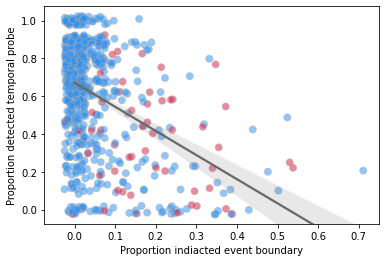

In [113]:
fig=plt.figure()

mask=~np.isnan(percentages_organized)*~np.isnan(detected_organized)
sns.regplot(percentages_organized,detected_organized,
            x_jitter=0.025,y_jitter=0.025,scatter_kws={'facecolors':np.array(arranged_colors)[mask],
                                                     'edgecolors':'darkgrey',
                                                     'alpha':0.5,'s':np.array(arranged_sizes)[mask]},
           line_kws={'color':'dimgrey'})

plt.ylim(-0.075,1.075)
plt.xlim(-0.075,0.75)
plt.xlabel('Proportion indiacted event boundary')
plt.ylabel('Proportion detected temporal probe')
print(len(percentages_organized[mask]))
print(stats.pearsonr(percentages_organized[mask],detected_organized[mask]))

fig.savefig('svgs/exp1_tempprobe/eventseg_corr_temporal_probe_colored.svg')

In [114]:
print('nonboundaries')
color_mask=np.array(arranged_colors)==color_dict['noboundary']
mask=~np.isnan(percentages_organized)*~np.isnan(detected_organized)*color_mask
print(stats.pearsonr(percentages_organized[mask],detected_organized[mask]))

print('boundaries')
color_mask=np.array(arranged_colors)!=color_dict['noboundary']
mask=~np.isnan(percentages_organized)*~np.isnan(detected_organized)*color_mask
print(stats.pearsonr(percentages_organized[mask],detected_organized[mask]))


nonboundaries
(-0.377883011090719, 2.0027528315735088e-23)
boundaries
(-0.265650495685702, 0.05219910704818952)


### Time course of detection accuracy changes 

In [44]:
# sigmoid function
def sigmoid(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

# a = curve's maximum value
# b = offset
# c = logistic growth rate (slope) 
# d = sigmoid's midpoint

In [45]:
top_distance=[]
top_spacebars=[]

histogram_dict_top=dict()

for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    space_bars=reorganized_data_dict[sub]['space_bars']
    is_probe=reorganized_data_dict[sub]['probe']
    
    for i, probe in enumerate(probe_names):
        
        if is_probe[i]==1:
            base=probe.split('/')[0]
            probe_num=probe.split('_')[-1].split('.')[0]

            if base not in histogram_dict_top.keys():
                histogram_dict_top[base]=dict()
                histogram_dict_top[base]['distances']=[]
                histogram_dict_top[base]['spacebars']=[]

            probe_num=probe.split('_')[-1].split('.')[0]

            boundary_locations=np.hstack(list(boundary_info[base].values()))

            distances=np.array(boundary_locations)-np.int(probe_num)
            space=space_bars[i]

            min_idx=np.argmin(np.abs(distances))

            # recode
            if np.isnan(space):
                space=0
            else:
                space=1

            top_distance.append(np.array(distances)[min_idx])
            top_spacebars.append(space)


            histogram_dict_top[base]['distances']=np.hstack((histogram_dict_top[base]['distances'],np.array(distances)[min_idx]))
            histogram_dict_top[base]['spacebars']=np.hstack((histogram_dict_top[base]['spacebars'],space))

In [46]:
top_actual_distances=[]     
top_actual_spaces=[]

for i in np.unique(top_distance):
    
    spaces=np.array(top_spacebars)[np.array(top_distance)==i]
    top_actual_distances.append(i)
    top_actual_spaces.append(np.mean(spaces))

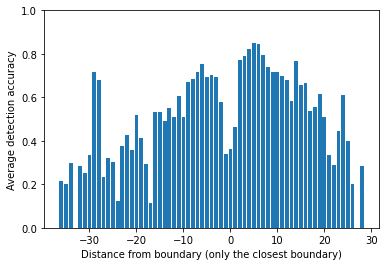

In [47]:
fig=plt.figure()

plt.bar(top_actual_distances,top_actual_spaces)
plt.ylim(0,1)
plt.xlabel('Distance from boundary (only the closest boundary)')
plt.ylabel('Average detection accuracy')

fig.savefig('svgs/exp1_tempprobe/detection_by_closest_distance_to_boundary.svg')

In [48]:
range_val=5
distance=np.arange(-range_val,range_val+1)
values=np.zeros((len(distance)))

for i, dist in enumerate(distance):
    print(np.sum(np.array(top_distance)==dist))

    values[i]=np.mean(np.array(top_spacebars)[np.array(top_distance)==dist])


189
235
240
231
394
479
385
274
297
230
214


[-0.34395952  0.69563867 20.54143018 -1.96682762]
[0.46615061 0.35683029 3.17530434 1.37339974]


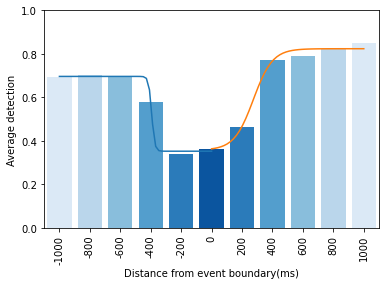

In [49]:
fig=plt.figure()

range_val=5
idx1=np.where(np.array(top_actual_distances)==-range_val)[0][0]
idx0=np.where(np.array(top_actual_distances)==0)[0][0]
idx2=np.where(np.array(top_actual_distances)==range_val+1)[0][0]

temp=sns.color_palette("Blues", n_colors=range_val+1)
colors=np.vstack((temp,sns.color_palette("Blues_r", n_colors=range_val+1)[1:]))

# pre boundary
popt, pcov = curve_fit(sigmoid, np.arange(-range_val,1), top_actual_spaces[idx1:idx0+1],method='lm',p0 = (1., 1., 1./90, 75.))
print(popt)

p0_prebound=popt

x = np.linspace(-range_val, 0, 50)
y = sigmoid(x, *popt)

plt.plot(x,y, label='fit')

# post boundary
popt, pcov = curve_fit(sigmoid, np.arange(0,range_val+1), top_actual_spaces[idx0:idx2],method='lm',p0 = (1., 1., 1./100, 75.))
print(popt)

p0_postbound=popt

x = np.linspace(0, range_val, 50)
y = sigmoid(x, *popt)

plt.plot(x,y, label='fit')


plt.bar(np.arange(-range_val,range_val+1),top_actual_spaces[idx1:idx2],color=colors)
plt.xlim(-range_val-.5,range_val+.5)
plt.ylim(0,1)
plt.xticks(np.arange(-range_val,range_val+1),np.arange(-range_val,range_val+1)*200,rotation=90)
plt.xlabel('Distance from event boundary(ms)')
plt.ylabel('Average detection')


fig.savefig('svgs/exp1_tempprobe/detection_by_closest_distance_to_boundary_zoomed_sigmoid.svg')


In [50]:
nPerm=1000
range_val=5
np.random.seed(0)
pre_slopes=np.zeros((nPerm))
post_slopes=np.zeros((nPerm))

pre_max=np.zeros((nPerm))
post_max=np.zeros((nPerm))

pre_sigs=[]
post_sigs=[]

distance=np.arange(-range_val,range_val+1)

perm_values=np.zeros((nPerm,len(distance)))

for p in range(nPerm):

    
    values=np.zeros((len(distance)))

    for i, dist in enumerate(distance):
        temp_values=np.array(top_spacebars)[np.array(top_distance)==dist]
        temp_idxs=np.random.choice(np.arange(len(temp_values)),size=len(temp_values),replace=True)
        values[i]=np.mean(temp_values[temp_idxs])
        
    try:
        popt, pcov = curve_fit(sigmoid, distance[:range_val+1], values[:range_val+1],method='lm',p0 = p0_prebound)
        pre_slopes[p]=popt[2]
        pre_max[p]=popt[0]
        
        x = np.linspace(-range_val, 0, 20)
        y = sigmoid(x, *popt)
        pre_sigs.append(y)

    except:
        pre_slopes[p]=np.nan
        pre_max[p]=np.nan
        pre_sigs.append([np.nan])
    
    # print(popt[2])
    #x = np.linspace(-range_val, 0, 50)
    #y = sigmoid(x, *popt)
    #plt.plot(distance[:range_val+1], values[:range_val+1], 'o', label='data')
    #plt.plot(x,y, label='fit')

    try:
        popt2, pcov2 = curve_fit(sigmoid, distance[-range_val-1:], values[-range_val-1:],method='lm',p0 = p0_postbound)
        post_slopes[p]=popt2[2]
        post_max[p]=popt2[0]
        x2 = np.linspace(0, range_val, 20)
        y2 = sigmoid(x2, *popt2)
        post_sigs.append(y2)

        
    except:
        post_slopes[p]=np.nan
        post_max[p]=np.nan
        post_sigs.append([np.nan])
        
    #print(popt2[2])
    #x2 = np.linspace(0, range_val, 20)
    #y2 = sigmoid(x, *popt)
    #plt.plot(distance[-range_val-1:], values[-range_val-1:], 'o', label='data')
    #plt.plot(x,y, label='fit')

    perm_values[p,:]=values

In [51]:
print(stats.ttest_ind(pre_slopes,post_slopes,nan_policy='omit'))
print(np.nanmean(np.log(pre_slopes)))
print(np.nanmean(np.log(post_slopes)))
print(np.sum(np.isnan(pre_slopes)))
print(np.sum(np.isnan(post_slopes)))

pval=np.sum((np.log(pre_slopes)-np.log(post_slopes))<=0)/nPerm*2
if pval>1:
    pval=2-pval
print(pval)

Ttest_indResult(statistic=50.54406726122383, pvalue=0.0)
2.8587495815907196
1.2312446691376473
0
1
0.168


[-0.34395952  0.69563867 20.64070976 -1.96698788]
[0.46615053 0.35683034 3.175308   1.37339961]


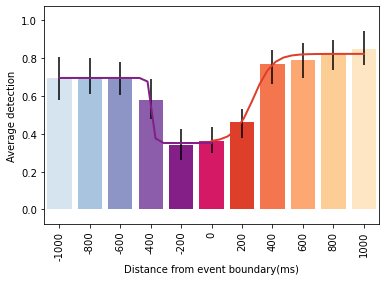

In [52]:
fig=plt.figure()

range_val=5
idx1=np.where(np.array(top_actual_distances)==-range_val)[0][0]
idx0=np.where(np.array(top_actual_distances)==0)[0][0]
idx2=np.where(np.array(top_actual_distances)==range_val+1)[0][0]

temp=sns.color_palette("BuPu", n_colors=range_val)
colors=np.vstack((temp,sns.color_palette("PuRd", n_colors=range_val+1)[-2],
                 sns.color_palette("OrRd_r", n_colors=range_val+1)[1:]))

# pre boundary
popt, pcov = curve_fit(sigmoid, np.arange(-range_val,1), top_actual_spaces[idx1:idx0+1],p0 = p0_prebound)
print(popt)

x = np.linspace(-range_val, 0, 20)
y = sigmoid(x, *popt)

plt.plot(x,y, label='fit',color=colors[4],linewidth=2)

# post boundary
popt, pcov = curve_fit(sigmoid, np.arange(0,range_val+1), top_actual_spaces[idx0:idx2],p0 = p0_postbound)
print(popt)

x = np.linspace(0, range_val, 20)
y = sigmoid(x, *popt)

plt.plot(x,y, label='fit',color=colors[6],linewidth=2)


plt.bar(np.arange(-range_val,range_val+1),top_actual_spaces[idx1:idx2],color=colors)
plt.errorbar(x=np.arange(-range_val,range_val+1),
             y=top_actual_spaces[idx1:idx2],
             yerr=np.vstack((top_actual_spaces[idx1:idx2]-np.min(perm_values,axis=0),
                                                        np.max(perm_values,axis=0)-top_actual_spaces[idx1:idx2])),
            fmt='None',ecolor='black')

plt.xlim(-range_val-.5,range_val+.5)
plt.ylim(0,1)
plt.xticks(np.arange(-range_val,range_val+1),np.arange(-range_val,range_val+1)*200,rotation=90)
plt.xlabel('Distance from event boundary(ms)')
plt.ylabel('Average detection')
plt.ylim(-0.075,1.075)

fig.savefig('svgs/exp1_tempprobe/detection_by_distance_to_boundary_zoomed_sigmoid_errors.svg')


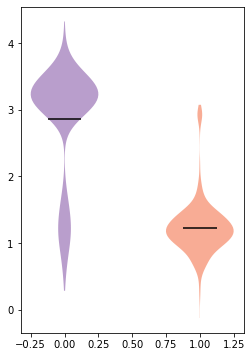

In [53]:
fig=plt.figure(figsize=(4,6))

v=plt.violinplot(np.log(pre_slopes)[~np.isnan(np.log(pre_slopes))],positions=[0],showextrema=False,showmeans=True)
v['bodies'][0].set_facecolor(colors[3])
v['bodies'][0].set_alpha(0.6)
v['cmeans'].set_color('black')

v=plt.violinplot(np.log(post_slopes)[~np.isnan(np.log(post_slopes))],positions=[1],showextrema=False,showmeans=True)
v['bodies'][0].set_facecolor(colors[7])
v['bodies'][0].set_alpha(0.6)
v['cmeans'].set_color('black')

fig.savefig('svgs/exp1_tempprobe/detection_by_distance_slopes.svg')


#### Different event types 

In [54]:
# collision containment falling occlusion
key='collision'

In [55]:
type_distance=[]
type_spacebars=[]

histogram_dict_type=dict()
for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    space_bars=reorganized_data_dict[sub]['space_bars']
    is_probe=reorganized_data_dict[sub]['probe']
    
    for i, probe in enumerate(probe_names):
        
        if is_probe[i]==1 and key in probe:
            base=probe.split('/')[0]
            probe_num=probe.split('_')[-1].split('.')[0]

            if base not in histogram_dict_type.keys():
                histogram_dict_type[base]=dict()
                histogram_dict_type[base]['distances']=[]
                histogram_dict_type[base]['spacebars']=[]

            boundary_locations=np.hstack(list(boundary_info[base][key]))

            distances=np.array(boundary_locations)-np.int(probe_num)
            space=space_bars[i]

            min_idx=np.argmin(np.abs(distances))

            # recode
            if np.isnan(space):
                space=0
            else:
                space=1

            type_distance.append(np.array(distances)[min_idx])
            type_spacebars.append(space)


            histogram_dict_type[base]['distances']=np.hstack((histogram_dict_type[base]['distances'],np.array(distances)[min_idx]))
            histogram_dict_type[base]['spacebars']=np.hstack((histogram_dict_type[base]['spacebars'],space))
            
type_actual_distances=[]     
type_actual_spaces=[]

for i in np.unique(type_distance):
    
    spaces=np.array(type_spacebars)[np.array(type_distance)==i]
    type_actual_distances.append(i)
    type_actual_spaces.append(np.mean(spaces))

[-0.36991312  0.70814841 21.28020432 -1.01184676]
[0.57598834 0.28471754 1.491105   1.74745021]


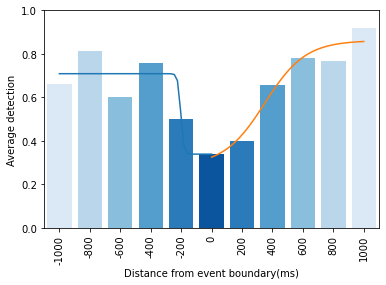

In [56]:
fig=plt.figure()

range_val=5
idx1=np.where(np.array(type_actual_distances)==-range_val)[0][0]
idx0=np.where(np.array(type_actual_distances)==0)[0][0]
idx2=np.where(np.array(type_actual_distances)==range_val+1)[0][0]

temp=sns.color_palette("Blues", n_colors=range_val+1)
colors=np.vstack((temp,sns.color_palette("Blues_r", n_colors=range_val+1)[1:]))


# pre boundary
popt, pcov = curve_fit(sigmoid, np.arange(-range_val,1), type_actual_spaces[idx1:idx0+1],method='lm',p0 = (1., 1., 1./90, 75.))
print(popt)

p0_prebound=popt

x = np.linspace(-range_val, 0, 50)
y = sigmoid(x, *popt)

plt.plot(x,y, label='fit')

# post boundary
popt, pcov = curve_fit(sigmoid, np.arange(0,range_val+1), type_actual_spaces[idx0:idx2],method='lm',p0 = (1., 1., 1./100, 75.))
print(popt)

p0_postbound=popt

x = np.linspace(0, range_val, 50)
y = sigmoid(x, *popt)

plt.plot(x,y, label='fit')

plt.bar(np.arange(-range_val,range_val+1),type_actual_spaces[idx1:idx2],color=colors)
plt.xlim(-range_val-.5,range_val+.5)
plt.ylim(0,1)
plt.xticks(np.arange(-range_val,range_val+1),np.arange(-range_val,range_val+1)*200,rotation=90)
plt.xlabel('Distance from event boundary(ms)')
plt.ylabel('Average detection')


fig.savefig('svgs/exp1_tempprobe/detection_by_closest_distance_to_%s.svg' % key)

In [57]:
nPerm=1000
range_val=5
np.random.seed(0)
pre_slopes=np.zeros((nPerm))
post_slopes=np.zeros((nPerm))

pre_max=np.zeros((nPerm))
post_max=np.zeros((nPerm))

pre_sigs=[]
post_sigs=[]

distance=np.arange(-range_val,range_val+1)

perm_values=np.zeros((nPerm,len(distance)))

for p in range(nPerm):

    
    values=np.zeros((len(distance)))

    for i, dist in enumerate(distance):
        temp_values=np.array(type_spacebars)[np.array(type_distance)==dist]
        temp_idxs=np.random.choice(np.arange(len(temp_values)),size=len(temp_values),replace=True)
        values[i]=np.mean(temp_values[temp_idxs])
        
    try:
        popt, pcov = curve_fit(sigmoid, distance[:range_val+1], values[:range_val+1],p0 = p0_prebound)
        pre_slopes[p]=popt[2]
        pre_max[p]=popt[0]
    except:
        pre_slopes[p]=np.nan
        pre_max[p]=np.nan
    
    # print(popt[2])
    #x = np.linspace(-range_val, 0, 50)
    #y = sigmoid(x, *popt)
    #plt.plot(distance[:range_val+1], values[:range_val+1], 'o', label='data')
    #plt.plot(x,y, label='fit')
    

    try:
        popt2, pcov2 = curve_fit(sigmoid, distance[-range_val-1:], values[-range_val-1:],p0 = p0_postbound)
        post_slopes[p]=popt2[2]
        post_max[p]=popt2[0]
    except:
        post_slopes[p]=np.nan
        post_max[p]=np.nan
        
    #print(popt2[2])
    #x2 = np.linspace(0, range_val, 20)
    #y2 = sigmoid(x, *popt)
    #plt.plot(distance[-range_val-1:], values[-range_val-1:], 'o', label='data')
    #plt.plot(x,y, label='fit')
    
    x = np.linspace(-range_val, 0, 20)
    y = sigmoid(x, *popt)
    pre_sigs.append(y)
    
    x2 = np.linspace(0, range_val, 20)
    y2 = sigmoid(x2, *popt2)
    post_sigs.append(y2)
    
    perm_values[p,:]=values

[-0.36991312  0.70814841 21.45438377 -1.01175013]
[0.57597649 0.28472468 1.49118992 1.74745239]


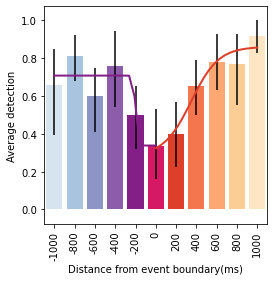

In [58]:
fig=plt.figure(figsize=(4,4))

range_val=5
idx1=np.where(np.array(type_actual_distances)==-range_val)[0][0]
idx0=np.where(np.array(type_actual_distances)==0)[0][0]
idx2=np.where(np.array(type_actual_distances)==range_val+1)[0][0]

temp=sns.color_palette("BuPu", n_colors=range_val)
colors=np.vstack((temp,sns.color_palette("PuRd", n_colors=range_val+1)[-2],
                 sns.color_palette("OrRd_r", n_colors=range_val+1)[1:]))

# pre boundary
popt, pcov = curve_fit(sigmoid, np.arange(-range_val,1), type_actual_spaces[idx1:idx0+1],p0 = p0_prebound)
print(popt)

x = np.linspace(-range_val, 0, 20)
y = sigmoid(x, *popt)

plt.plot(x,y, label='fit',color=colors[4],linewidth=2)

# post boundary
popt, pcov = curve_fit(sigmoid, np.arange(0,range_val+1), type_actual_spaces[idx0:idx2],p0 = p0_postbound)
print(popt)

x2 = np.linspace(0, range_val, 20)
y2 = sigmoid(x2, *popt)

plt.plot(x2,y2, label='fit',color=colors[6],linewidth=2)


plt.bar(np.arange(-range_val,range_val+1),type_actual_spaces[idx1:idx2],color=colors)
plt.errorbar(x=np.arange(-range_val,range_val+1),
             y=type_actual_spaces[idx1:idx2],
             yerr=np.vstack((type_actual_spaces[idx1:idx2]-np.min(perm_values,axis=0),
                                                        np.max(perm_values,axis=0)-type_actual_spaces[idx1:idx2])),
            fmt='None',ecolor='black')

plt.xlim(-range_val-.5,range_val+.5)
plt.ylim(0,1)
plt.xticks(np.arange(-range_val,range_val+1),np.arange(-range_val,range_val+1)*200,rotation=90)
plt.xlabel('Distance from event boundary(ms)')
plt.ylabel('Average detection')
plt.ylim(-0.075,1.075)

fig.savefig('svgs/exp1_tempprobe/detection_by_distance_to_%s_zoomed_sigmoid_errors.svg' % key)


In [59]:
print('Pre slope:',np.nanmean(pre_slopes))
print(np.nanmean(np.log(pre_slopes)))
print('Number of pre slope fails:',np.sum(np.isnan(pre_slopes)))
print('Post slope:',np.nanmean(post_slopes))
print(np.nanmean(np.log(post_slopes)))
print('Number of post slope fails:',np.sum(np.isnan(post_slopes)))
print()

pval=np.sum((np.log(pre_slopes)-np.log(post_slopes))<=0)/nPerm*2
if pval>1:
    pval=2-pval
    
print(pval)

Pre slope: 124.22391276328386
3.626460950888723
Number of pre slope fails: 39
Post slope: 4.351065781234532
0.779692063124782
Number of post slope fails: 159

0.048


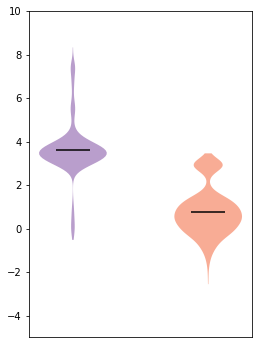

In [60]:
fig=plt.figure(figsize=(4,6))

v=plt.violinplot(np.log(pre_slopes)[~np.isnan(np.log(pre_slopes))],positions=[0],showextrema=False,showmeans=True)
v['bodies'][0].set_facecolor(colors[3])
v['bodies'][0].set_alpha(0.6)
v['cmeans'].set_color('black')

v=plt.violinplot(np.log(post_slopes)[~np.isnan(np.log(post_slopes))],positions=[1],showextrema=False,showmeans=True)
v['bodies'][0].set_facecolor(colors[7])
v['bodies'][0].set_alpha(0.6)
v['cmeans'].set_color('black')
plt.xticks([])
plt.ylim(-5,10)
fig.savefig('svgs/exp1_tempprobe/detection_by_distance_slopes_%s.svg' %(key))

### Confidence

In [216]:
all_probes_boundaries_conf=[]
all_probes_nonboundaries_conf=[]

num_bounds=[]
num_nonbounds=[]
for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_boundaries_conf=[]
    probes_non_boundaries_conf=[]
    
    for i, probe in enumerate(probe_names):

        if reorganized_data_dict[sub]['probe'][i]==1: # if its a probe trial 
            base=probe.split('/')[0]
            probe_num=probe.split('_')[-1].split('.')[0]

            boundary_locations=np.hstack(list(boundary_info[base].values()))

            if np.int(probe_num) in boundary_locations:
                probes_boundaries_conf.append(int(reorganized_data_dict[sub]['confidence'][i]))

            else:
                probes_non_boundaries_conf.append(int(reorganized_data_dict[sub]['confidence'][i]))
                
    all_probes_boundaries_conf.append(np.nanmean(probes_boundaries_conf))
    all_probes_nonboundaries_conf.append(np.nanmean(probes_non_boundaries_conf))

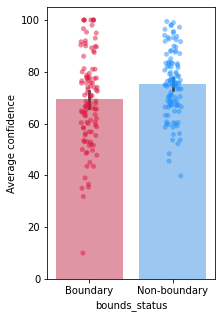

In [217]:
fig=plt.figure(figsize=(3,5))
bounds_detect_df=pd.DataFrame({'vals':np.hstack((all_probes_boundaries_conf,all_probes_nonboundaries_conf)),
                               'bounds_status':np.hstack((np.zeros(len(all_probes_boundaries_conf)),
                                                          np.ones(len(all_probes_nonboundaries_conf))))})

sns.barplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['crimson','dodgerblue'],alpha=0.5)
sns.stripplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['crimson','dodgerblue'],alpha=0.5)
plt.xticks([0,1],['Boundary','Non-boundary'])
plt.ylabel('Average confidence')

fig.savefig('svgs/exp1_tempprobe/subjectwise_boundary_confidence.svg')

In [218]:
print(np.nanmean(all_probes_boundaries_conf))
print(np.nanmean(all_probes_nonboundaries_conf))

69.4553902116402
75.43466600363438


In [219]:
stats.ttest_rel(all_probes_boundaries_conf,all_probes_nonboundaries_conf,nan_policy='omit')

Ttest_relResult(statistic=-5.515393981441809, pvalue=2.438176801064498e-07)

(-0.201986425674214, 6.743175960912274e-08)


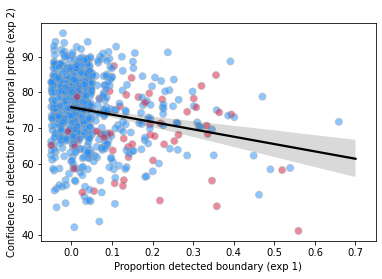

In [220]:
fig=plt.figure()

mask=~np.isnan(percentages_organized)*~np.isnan(confidence_organized)
sns.regplot(percentages_organized,confidence_organized,
            x_jitter=0.05,y_jitter=0.05,scatter_kws={'facecolors':np.array(arranged_colors)[mask],
                                                     'edgecolors':'darkgrey',
                                                     'alpha':0.5,'s':np.array(arranged_sizes)[mask]},
           line_kws={'color':'black'})

#plt.ylim(-0.075,1.075)
plt.xlim(-0.075,0.75)
plt.xlabel('Proportion detected boundary (exp 1)')
plt.ylabel('Confidence in detection of temporal probe (exp 2)')
print(stats.pearsonr(percentages_organized[mask],confidence_organized[mask]))

fig.savefig('svgs/exp1_tempprobe/eventseg_corr_temporal_probe_conf_colored.svg')

In [221]:
print('nonboundaries')
color_mask=np.array(arranged_colors)==color_dict['noboundary']
mask=~np.isnan(percentages_organized)*~np.isnan(confidence_organized)*color_mask
print(stats.pearsonr(percentages_organized[mask],confidence_organized[mask]))

print('boundaries')
color_mask=np.array(arranged_colors)!=color_dict['noboundary']
mask=~np.isnan(percentages_organized)*~np.isnan(confidence_organized)*color_mask
print(stats.pearsonr(percentages_organized[mask],confidence_organized[mask]))

nonboundaries
(-0.1441644867498195, 0.00023141675327052324)
boundaries
(-0.13230829584259923, 0.34022786407435746)


In [223]:
# building the model and fitting the data
glm_reg = mixedlm(formula=('confidence ~ pixels + C(condition)'), data=all_trial_df,
                 groups=all_trial_df['subject']).fit()

# printing the summary table
print(glm_reg.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  confidence 
No. Observations:   6231     Method:              REML       
No. Groups:         109      Scale:               377.3283   
Min. group size:    26       Log-Likelihood:      -27494.0534
Max. group size:    64       Converged:           Yes        
Mean group size:    57.2                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          73.952    1.248 59.246 0.000 71.506 76.399
C(condition)[T.1]  -6.974    0.933 -7.472 0.000 -8.803 -5.144
pixels             31.497    5.231  6.021 0.000 21.245 41.749
Group Var         155.857    1.151                           



### RT Info

In [224]:
all_probes_boundaries_rts=[]
all_probes_nonboundaries_rts=[]

num_bounds=[]
num_nonbounds=[]
for sub in reorganized_data_dict.keys():
    probe_names=reorganized_data_dict[sub]['names']
    
    probes_boundaries_rts=[]
    probes_non_boundaries_rts=[]
    
    for i, probe in enumerate(probe_names):

        if reorganized_data_dict[sub]['probe'][i]==1 and ~np.isnan(reorganized_data_dict[sub]['space_bars'][i]): # if its a probe trial 
            base=probe.split('/')[0]
            probe_num=probe.split('_')[-1].split('.')[0]

            boundary_locations=np.hstack(list(boundary_info[base].values()))

            if np.int(probe_num) in boundary_locations:
                probes_boundaries_rts.append(float(reorganized_data_dict[sub]['rts'][i]))

            else:
                probes_non_boundaries_rts.append(float(reorganized_data_dict[sub]['rts'][i]))
    
    print(sub,len(probes_boundaries_rts),len(probes_non_boundaries_rts))            
    all_probes_boundaries_rts.append(np.nanmean(probes_boundaries_rts))
    all_probes_nonboundaries_rts.append(np.nanmean(probes_non_boundaries_rts))

debug07BY44:debugBE7Z9N 0 10
debug0J9fw:debug39W0J 2 54
debug0izns:debugZ2iHU 5 46
debug19lMm:debugUiFNq 1 36
debug1YAUU:debugJPQAT 0 33
debug26vse:debugR3Agl 0 17
debug2FTyl:debugGncPa 3 36
debug2LvDu:debugV32zh 0 51
debug2Mj1Y:debugBBWKj 2 44
debug2ieYE:debug92sb7 0 3
debug30eYX:debugpwEKv 1 4
debug4Kps0:debug4fG4D 0 0
debug7Eumu:debug4btcn 1 26
debug7hwht:debugz5Nro 1 46
debug8W1Uy:debugj2L8M 5 32
debug9BEep:debugtTzA2 1 32
debug9GH3Y:debugo010z 2 35
debug9wyVB:debugcIcCI 3 35
debugBKsVe:debugN7mkh 1 35
debugBbmu1:debugfJzHl 1 33
debugBx23R:debug52cgy 0 12
debugCncNG:debugbwj5M 0 34
debugDF3t3:debugDCEN9 1 40
debugDOgWA:debugEG23M 2 51
debugEeE98:debugDbY3a 0 23
debugEx8wN:debuggOnms 4 42
debugFLCue:debugEPGon 0 0
debugFPHyC:debugVd1hA 0 20
debugFmqbJ:debugmHku2 1 27
debugG2GQq:debugmAPMC 3 37
debugH1RD6:debugJW1Vh 3 38
debugHCXMt:debugpkyAP 4 37
debugJ001d:debugWtcvu 0 2
debugJrXob:debugkIH1E 0 34
debugLUdoV:debugxVWQ4 0 16
debugMC59V:debugZ7I6l 0 3
debugNoi0G:debugCt04Y 2 46
debug

In [225]:
np.sum(~np.isnan(all_probes_boundaries_rts))

78

In [226]:
np.sum(~np.isnan(all_probes_nonboundaries_rts))

107

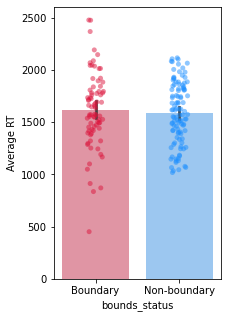

In [227]:
fig=plt.figure(figsize=(3,5))
bounds_detect_df=pd.DataFrame({'vals':np.hstack((all_probes_boundaries_rts,all_probes_nonboundaries_rts)),
                               'bounds_status':np.hstack((np.zeros(len(all_probes_boundaries_rts)),
                                                          np.ones(len(all_probes_nonboundaries_rts))))})

sns.barplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['crimson','dodgerblue'],alpha=0.5)
sns.stripplot(x='bounds_status',y='vals',data=bounds_detect_df,palette=['crimson','dodgerblue'],alpha=0.5)
plt.xticks([0,1],['Boundary','Non-boundary'])
plt.ylabel('Average RT')

fig.savefig('svgs/exp1_tempprobe/subjectwise_boundary_rts.svg')

In [228]:
print(np.nanmean(all_probes_boundaries_rts))
print(np.nanmean(all_probes_nonboundaries_rts))

1616.8459401709401
1586.360668416502


In [229]:
stats.ttest_rel(all_probes_boundaries_rts,all_probes_nonboundaries_rts,nan_policy='omit')

Ttest_relResult(statistic=1.9153266235573598, pvalue=0.0591640888032727)

(0.04825386355298541, 0.21922752809054255)


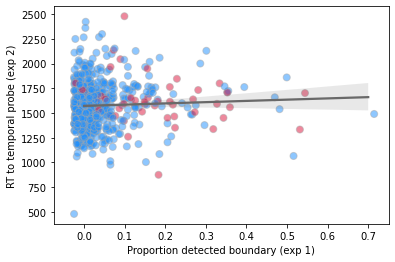

In [230]:
fig=plt.figure()

mask=~np.isnan(percentages_organized)*~np.isnan(rt_organized)
sns.regplot(percentages_organized,rt_organized,
            x_jitter=0.025,y_jitter=0.025,scatter_kws={'facecolors':np.array(arranged_colors)[mask],
                                                     'edgecolors':'darkgrey',
                                                     'alpha':0.5,'s':np.array(arranged_sizes)[mask]},
           line_kws={'color':'dimgrey'})

#plt.ylim(-0.075,1.075)
plt.xlim(-0.075,0.75)
plt.xlabel('Proportion detected boundary (exp 1)')
plt.ylabel('RT to temporal probe (exp 2)')
print(stats.pearsonr(percentages_organized[mask],rt_organized[mask]))

fig.savefig('svgs/exp1_tempprobe/eventseg_corr_temporal_probe_rt_colored.svg')

In [231]:
print('nonboundaries')
color_mask=np.array(arranged_colors)==color_dict['noboundary']
mask=~np.isnan(percentages_organized)*~np.isnan(rt_organized)*color_mask
print(stats.pearsonr(percentages_organized[mask],rt_organized[mask]))

print('boundaries')
color_mask=np.array(arranged_colors)!=color_dict['noboundary']
mask=~np.isnan(percentages_organized)*~np.isnan(rt_organized)*color_mask
print(stats.pearsonr(percentages_organized[mask],rt_organized[mask]))

nonboundaries
(0.06078757181473327, 0.13563995168392828)
boundaries
(-0.21747478930587757, 0.14654760008242254)


In [232]:
# some NANs in RTs as well -- need to delete
subset_trial_df= all_trial_df.dropna(subset=['RTs'])
print(len(subset_trial_df))
subset_trial_df.head()


3784


,subject,pixels,detection,confidence,RTs,condition
0,debug07BY44:debugBE7Z9N,0.017284,1.0,36.0,857.0,0
4,debug07BY44:debugBE7Z9N,0.083869,1.0,54.0,1069.0,0
5,debug07BY44:debugBE7Z9N,0.058440,1.0,35.0,1284.0,0
6,debug07BY44:debugBE7Z9N,0.039977,1.0,49.0,1094.0,0
14,debug07BY44:debugBE7Z9N,0.023261,1.0,25.0,1911.0,0


In [234]:
# building the model and fitting the data
glm_reg = mixedlm(formula=('RTs ~ pixels + C(condition)'), data=all_trial_df,missing='drop',
              groups=all_trial_df['subject']).fit()

# printing the summary table
print(glm_reg.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    RTs        
No. Observations:      3784       Method:                REML       
No. Groups:            107        Scale:                 68803.3543 
Min. group size:       2          Log-Likelihood:        -26623.4621
Max. group size:       56         Converged:             Yes        
Mean group size:       35.4                                         
--------------------------------------------------------------------
                    Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
Intercept          1626.472   29.315 55.483 0.000  1569.016 1683.928
C(condition)[T.1]    69.626   20.722  3.360 0.001    29.012  110.239
pixels             -999.436  174.892 -5.715 0.000 -1342.217 -656.654
Group Var         81280.833   44.601                                

